### Importing necessary libraries

In [1]:
import shutil
import rasterio
import json
import glob
import pandas as pd
import os
import random
import numpy as np

import cv2

### Defining Functions

**A function to check if the first band of the satellite is empty (all zeros for pixels)**

In [4]:
def check_empty_img(url):
    image = cv2.imread(url+'\\B01.tif',0)
    if (cv2.countNonZero(image) == 0):
        return True
    else:
        return False

**This function takes 4 bands and it stacks them into a single image**

In [6]:
def stack_bands(path, product_id):
    print(path)

    band_list = ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']
    try:

        with rasterio.open(path + '\\' + band_list[0]) as src0:
            meta = src0.meta

        meta.update(count = len(band_list))

        with rasterio.open(path + '\\' + 'stack.tif', 'w', **meta) as dst:
            for idd, layer in enumerate(band_list, start=1):
                with rasterio.open(path + '\\' + layer) as src1:
                    dst.write_band(idd, src1.read(1))

    except:
        print("Folder with no Data")
        remove_empty_folders(path)

        pass

In [7]:
def product_name(path):
    json_data = open(path + "\\stac.json", "rb")
    jdata = json.load(json_data)

    return jdata['id']

**This function deletes a folder and its contents if no spectral band is included**

In [13]:
def remove_empty_folders(path):
    try:
        if os.path.exists(path) and os.path.isdir(path):
            shutil.rmtree(path)
            print(f"Deleted folder: {path}")
        else:
            print(f"Path does not exist or is not a directory: {path}")
    except Exception as e:
        print(f"Error while deleting folder {e}")

In [15]:
def label(path):
    return

### Iterate through Folders

**Create a list with all the folders containing spectral bands**

In [19]:
flist = []
root_dir = 'C:\\Users\\eyram\\Downloads\\flood_sat_images\\sen12flood\\sen12floods_s2_source\\sen12floods_s2_source'
for file in os.listdir(root_dir):
    d = os.path.join(root_dir, file)
    if os.path.isdir(d):
        flist.append(d)


print(f"The number of folders are currently = {len(flist)}")

The number of folders are currently = 1949


Iterate through all folders and create a new image with 4 sprectral bands.  
These bands correspond to blue, green, red, and infrared respectively.

In [22]:
for folder_path in flist:
    empty = check_empty_img(folder_path)
    if empty:
        print("The images inside the current folder are empty (zero pixels)")
        remove_empty_folders(folder_path)
    else:
        product_id = product_name(folder_path)
        stack_bands(folder_path, product_id)

C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2018_12_18
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2018_12_23
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2019_01_02
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2019_01_12
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2019_01_17
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2019_01_22
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source\sen12floods_s2_source_0001_2019_01_27
C:\Users\eyram\Downloads\flood_sat_images\sen12flood\se

In [24]:
flist_new = []
root_dir = r"C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_source\sen12floods_s2_source"
for file in os.listdir(root_dir):
    d = os.path.join(root_dir, file)
    if os.path.isdir(d):
        flist_new.append(d)



print(f"The number of folders after the pre-processing = {len(flist_new)}")

The number of folders after the pre-processing = 1949


### Modelling - (Preparing Data and Building Model Architecture)

In [27]:
# The folder path where the labels are stored
labels_path = r"C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_labels"

**This function goes through the root directory and splits entire dataset into train and test sets**

In [30]:
def split_dataset(root_dir, output_dir, train_ratio = 0.7):
    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Shuffle the folder list
    random.shuffle(flist_new)

    # Split the folders
    split_index = int(len(flist_new) * train_ratio)
    train_folders = flist_new[:split_index]
    test_folders = flist_new[split_index:]

    # Copy the contents of train folders
    for folder in train_folders:
        folder_name = os.path.basename(folder)
        target_dir = os.path.join(train_dir, folder_name)
        shutil.copytree(folder, target_dir)

    # Copy the contents of test folders
    for folder in test_folders:
        folder_name = os.path.basename(folder)
        target_dir = os.path.join(test_dir, folder_name)
        shutil.copytree(folder, target_dir)

    print(f"Training folders: {len(train_folders)}")
    print(f"Testing folders: {len(test_folders)}")
    print(f"Dataset split completed. Train: {train_dir}, Test: {test_dir}")

In [34]:
output_directory = r"C:\Users\eyram\Downloads\flood_sat_images\sen12flood\split_dataset"
split_dataset(flist_new, output_directory, train_ratio=0.7)

Training folders: 1364
Testing folders: 585
Dataset split completed. Train: C:\Users\eyram\Downloads\flood_sat_images\sen12flood\split_dataset\train, Test: C:\Users\eyram\Downloads\flood_sat_images\sen12flood\split_dataset\test


In [36]:
# Local folders for the train and test images
training_images_path = r"C:\Users\eyram\Downloads\flood_sat_images\sen12flood\split_dataset\train"

testing_images_path = r"C:\Users\eyram\Downloads\flood_sat_images\sen12flood\split_dataset\test"

**The following function accepts the name of the image as an argument and it searches for the corresponding label.**  
**If the image depicts a flooded area then it returns the number one (1), otherwise it returns zero (0).**

In [39]:
def image_label(product_id):

    root_dir = r"C:\Users\eyram\Downloads\flood_sat_images\sen12flood\sen12floods_s2_labels\sen12floods_s2_labels"
    pd_split = product_id.split("_")
    pd = "_".join(pd_split[3:7])
    new_pd = "sen12floods_s2_labels_" + pd

    json_path = os.path.join(root_dir, new_pd, "stac.json")

    try:
        with open(json_path, "rb") as json_file:
            jdata = json.load(json_file)
            flood = jdata["properties"]["FLOODING"]
            return 0 if flood == "False" else 1
    except FileNotFoundError:
        print(f"File not found: {json_path}")
        return None

    

**This function accepts the path to the folder as an argument where the image is stored.**  
**Inside this folder there is a JSON file containing the product id as a property, it returns the product id.**

In [42]:
def product_name(path):

    json_data = open(path + "\stac.json", "rb")
    jdata = json.load(json_data)

    return jdata['id']

**The following function is responsible for constructing the dataset in a way compatible with Keras.**  
**It iterates through folders and searches for images along with their corresponding label.**

In [45]:
def load_data(imagelist):

    data = []
    images = []
    labels = []

    for folder in imagelist:
        try:
            
            product_id = product_name(folder)
            print(f"Processing {product_id} image product")
            label = image_label(product_id)

            # Open the image
            image_path = os.path.join(folder, "stack.tif")
            image = cv2.imread(image_path)               
            if image is None:
                               
                print(f"Failed to load image: {image_path}")
                continue
                
            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)
        except Exception as e:
            print(f"Error processing folder {folder}: {e}")

    print(f"Number of image loaded: {len(images)}")
    print(f"Number of labels loaded: {len(labels)}")

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    data.append([images, labels])
    return images, labels

### Loading the Training Dataset

In [48]:
train_imagelist = []
test_imagelist = []

In [50]:
root_dir = training_images_path
for file in os.listdir(root_dir):
    d = os.path.join(root_dir, file)
    if os.path.isdir(d):
        train_imagelist.append(d)

print(f"The number of training samples is currently = {len(train_imagelist)}")

The number of training samples is currently = 1364


In [79]:
train_images, train_labels = load_data(train_imagelist)

Processing sen12floods_s2_source_0001_2018_12_18 image product
Processing sen12floods_s2_source_0001_2018_12_23 image product
Processing sen12floods_s2_source_0001_2019_01_02 image product
Processing sen12floods_s2_source_0001_2019_01_12 image product
Processing sen12floods_s2_source_0001_2019_01_17 image product
Processing sen12floods_s2_source_0001_2019_01_22 image product
Processing sen12floods_s2_source_0001_2019_02_01 image product
Processing sen12floods_s2_source_0001_2019_02_06 image product
Processing sen12floods_s2_source_0004_2018_12_17 image product
Processing sen12floods_s2_source_0004_2018_12_22 image product
Processing sen12floods_s2_source_0004_2019_01_16 image product
Processing sen12floods_s2_source_0005_2018_12_17 image product
Processing sen12floods_s2_source_0005_2018_12_22 image product
Processing sen12floods_s2_source_0005_2019_01_06 image product
Processing sen12floods_s2_source_0006_2018_12_17 image product
Processing sen12floods_s2_source_0006_2018_12_22 image 

### Loading the Test Dataset

In [52]:
root_dir = testing_images_path
for file in os.listdir(root_dir):
    d = os.path.join(root_dir, file)
    if os.path.isdir(d):
        test_imagelist.append(d)

print(f"The number of testing samples is = {len(test_imagelist)}")

The number of testing samples is = 585


In [54]:
test_images, test_labels = load_data(test_imagelist)

Processing sen12floods_s2_source_0001_2019_01_27 image product
Processing sen12floods_s2_source_0005_2019_01_16 image product
Processing sen12floods_s2_source_0006_2019_01_06 image product
Processing sen12floods_s2_source_0007_2019_01_14 image product
Processing sen12floods_s2_source_0007_2019_01_19 image product
Processing sen12floods_s2_source_0007_2019_01_29 image product
Processing sen12floods_s2_source_0007_2019_02_03 image product
Processing sen12floods_s2_source_0009_2018_12_25 image product
Processing sen12floods_s2_source_0009_2019_01_09 image product
Processing sen12floods_s2_source_0010_2019_01_19 image product
Processing sen12floods_s2_source_0010_2019_01_24 image product
Processing sen12floods_s2_source_0011_2018_12_30 image product
Processing sen12floods_s2_source_0011_2019_01_24 image product
Processing sen12floods_s2_source_0012_2019_01_24 image product
Processing sen12floods_s2_source_0012_2019_02_03 image product
Processing sen12floods_s2_source_0013_2018_12_30 image 

### Exploring the Train and Test Datasets

In [57]:
(unique, counts) = np.unique(test_labels, return_counts=True)

print(f"The number of images in the test dataset containing flooded areas is {counts[1]}\n")
print(f"While the number of images that do not contain flooded areas is {counts[0]}")

The number of images in the test dataset containing flooded areas is 121

While the number of images that do not contain flooded areas is 464


In [81]:
(unique, counts) = np.unique(train_labels, return_counts=True)

print(f"The number of images in the train dataset containing flooded areas is {counts[1]}\n")
print(f"While the number of image that do not contain flooded areas in {counts[0]}")

The number of images in the train dataset containing flooded areas is 328

While the number of image that do not contain flooded areas in 1036


### Building the Model

In [61]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import pydot
import tensorflow as tf

In [62]:
model = Sequential()

In [65]:
model.add(Input(shape=(512,512,3)))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))



model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [67]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 510, 510, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 510, 510, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 255, 255, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 253, 253, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 253, 253, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 508032)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      65,028,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,039,394 (248.11 MB)

 Trainable params: 65,039,010 (248.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [69]:
import sys

In [71]:
original_stdout = sys.stdout
with open('model_summary.txt', 'w') as f:
    sys.stdout = f
    model.summary()
    sys.stdout = original_stdout

Model: "sequential"

+--------------------------------------------------------------------------------------+
| Layer (type)                         | Output Shape                |         Param # |
|--------------------------------------+-----------------------------+-----------------|
| conv2d (Conv2D)                      | (None, 510, 510, 32)        |             896 |
|--------------------------------------+-----------------------------+-----------------|
| batch_normalization                  | (None, 510, 510, 32)        |             128 |
| (BatchNormalization)                 |                             |                 |
|--------------------------------------+-----------------------------+-----------------|
| max_pooling2d (MaxPooling2D)         | (None, 255, 255, 32)        |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dropout (Dropout)                    | (None, 255, 255, 32)        |               0 |
|--------------------------------------+-----------------------------+-----------------|
| conv2d_1 (Conv2D)                    | (None, 253, 253, 32)        |           9,248 |
|--------------------------------------+-----------------------------+-----------------|
| batch_normalization_1                | (None, 253, 253, 32)        |             128 |
| (BatchNormalization)                 |                             |                 |
|--------------------------------------+-----------------------------+-----------------|
| max_pooling2d_1 (MaxPooling2D)       | (None, 126, 126, 32)        |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dropout_1 (Dropout)                  | (None, 126, 126, 32)        |               0 |
|--------------------------------------+-----------------------------+-----------------|
| flatten (Flatten)                    | (None, 508032)              |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dense (Dense)                        | (None, 128)                 |      65,028,224 |
|--------------------------------------+-----------------------------+-----------------|
| batch_normalization_2                | (None, 128)                 |             512 |
| (BatchNormalization)                 |                             |                 |
|--------------------------------------+-----------------------------+-----------------|
| dropout_2 (Dropout)                  | (None, 128)                 |               0 |
|--------------------------------------+-----------------------------+-----------------|
| dense_1 (Dense)                      | (None, 2)                   |             258 |
+--------------------------------------------------------------------------------------+

 Total params: 65,039,394 (248.11 MB)

 Trainable params: 65,039,010 (248.10 MB)

 Non-trainable params: 384 (1.50 KB)

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
batch_size = 28
epochs = 20

In [83]:
model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.5866 - loss: 1.2047 - val_accuracy: 0.7729 - val_loss: 1.0991
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7581 - loss: 0.5685 - val_accuracy: 0.7692 - val_loss: 2.8883
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.7901 - loss: 0.5058 - val_accuracy: 0.7766 - val_loss: 10.7067
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8196 - loss: 0.4411 - val_accuracy: 0.7802 - val_loss: 17.4369
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8390 - loss: 0.4233 - val_accuracy: 0.7766 - val_loss: 9.2456
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.8821 - loss: 0.3504 - val_accuracy: 0.7802 - val_loss: 6.3759
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9152 - loss: 0.2365 - val_accuracy: 0.7802 - val_loss: 5.7268
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.9033 - loss: 0.2811 - val_accuracy: 0.7802 -

In [87]:
model_loss = pd.DataFrame(model.history.history)

In [89]:
model_loss[['accuracy', 'val_accuracy']].plot

### Visualizing Model Performance

In [92]:
model_loss

,accuracy,loss,val_accuracy,val_loss
0,0.627864,1.004295,0.772894,1.099105
1,0.750687,0.587961,0.769231,2.888338
2,0.787351,0.516630,0.776557,10.706737
3,0.824015,0.464653,0.780220,17.436905
4,0.845096,0.405919,0.776557,9.245641
5,0.885426,0.323830,0.780220,6.375938
6,0.903758,0.252938,0.780220,5.726759
7,0.902841,0.252187,0.780220,3.918710
8,0.945005,0.173589,0.780220,1.721422
9,0.956004,0.132500,0.780220,2.527914


In [94]:
def plot_accuracy_loss(model_loss):
    """
    Plot the accuracy and the loss using data from a DataFrame.
    """
    fig = plt.figure(figsize=(10, 5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(model_loss['accuracy'], 'bo--', label="Train Accuracy")
    plt.plot(model_loss['val_accuracy'], 'ro--', label="Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(model_loss['loss'], 'bo--', label="Train Loss")
    plt.plot(model_loss['val_loss'], 'ro--', label="Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

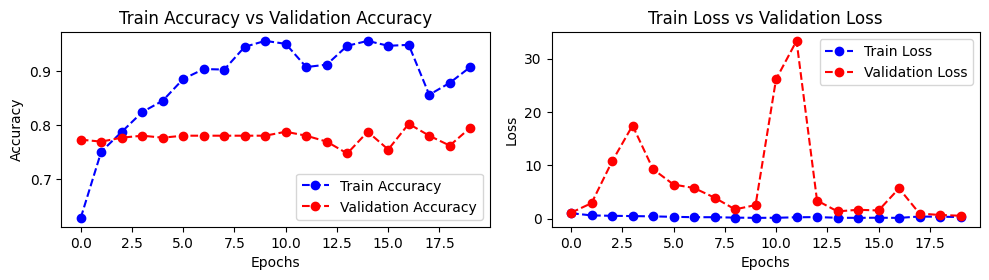

In [96]:
plot_accuracy_loss(model_loss)


In [98]:
test_loss = model.evaluate(test_images, test_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.8568 - loss: 0.3415


In [101]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [132]:
predictions = model.predict(test_images)

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step


In [136]:
predictions

array([[9.8438835e-01, 1.5611600e-02],
       [9.9707007e-01, 2.9298728e-03],
       [9.9860162e-01, 1.3983686e-03],
       ...,
       [9.9979895e-01, 2.0111517e-04],
       [9.7936398e-01, 2.0636015e-02],
       [9.8419660e-01, 1.5803328e-02]], dtype=float32)

In [138]:
pred_labels = np.argmax(predictions, axis=1)

In [140]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       464
           1       0.61      0.30      0.40       121

    accuracy                           0.82       585
   macro avg       0.72      0.62      0.65       585
weighted avg       0.79      0.82      0.79       585



### Transfer Learning using DenseNet121

In [143]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.image import resize
from tensorflow.keras.optimizers import Adam

In [145]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [146]:
base_model.trainable = False

### Get the features directly from DenseNet121

In [150]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 492ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 464ms/step


In [152]:
train_images.shape

(1364, 512, 512, 3)

**The function below preprocesses the images to match DenseNet121's expected input**

In [155]:
# Preprocess train_images
def preprocess_images(images):
    processed_images = []
    for img in images:
        resized_img = resize(img, (224,224))
        preprocessed_img = preprocess_input(resized_img.numpy())
        processed_images.append(preprocessed_img)
    return np.array(processed_images)

In [157]:
# Apply preprocessing
train_images_resized = preprocess_images(train_images)
test_images_resized = preprocess_images(test_images)

In [158]:
print(f"Processed train_images shape: {train_images_resized.shape}")
print(f"Processed test_images shape: {test_images_resized.shape}")

Processed train_images shape: (1364, 224, 224, 3)
Processed test_images shape: (585, 224, 224, 3)


In [161]:
# Adding custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Final Output Layer
output_layer = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

In [163]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )

In [165]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 7,694,146 (29.35 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [167]:
epochs = 20
batch_size = 32

In [169]:
model.fit(
    train_images_resized,
    train_labels,
    validation_data=(test_images_resized, test_labels),
    epochs=epochs,
    batch_size=batch_size,
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6924 - loss: 0.6403 - val_accuracy: 0.7932 - val_loss: 0.4682
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7216 - loss: 0.5691 - val_accuracy: 0.7983 - val_loss: 0.4513
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7528 - loss: 0.5306 - val_accuracy: 0.7966 - val_loss: 0.4402
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7687 - loss: 0.5051 - val_accuracy: 0.8034 - val_loss: 0.4324
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7758 - loss: 0.4668 - val_accuracy: 0.8034 - val_loss: 0.4203
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8081 - loss: 0.4166 - val_accuracy: 0.8171 - val_loss: 0.4211
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7705 - loss: 0.4704 - val_accuracy: 0.8171 - val_loss: 0.4153
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7893 - loss: 0.4308 - val_accuracy: 0.8171 - val_loss:

In [171]:
model_history = pd.DataFrame(model.history.history)

In [173]:
model_history

,accuracy,loss,val_accuracy,val_loss
0,0.712610,0.623892,0.793162,0.468204
1,0.727273,0.572873,0.798291,0.451304
2,0.753666,0.511921,0.796581,0.440160
3,0.756598,0.502402,0.803419,0.432441
4,0.777859,0.468427,0.803419,0.420265
5,0.782258,0.449972,0.817094,0.421110
6,0.771994,0.456860,0.817094,0.415309
7,0.786657,0.439601,0.817094,0.402457
8,0.795455,0.420731,0.820513,0.396481
9,0.795455,0.416362,0.825641,0.396966


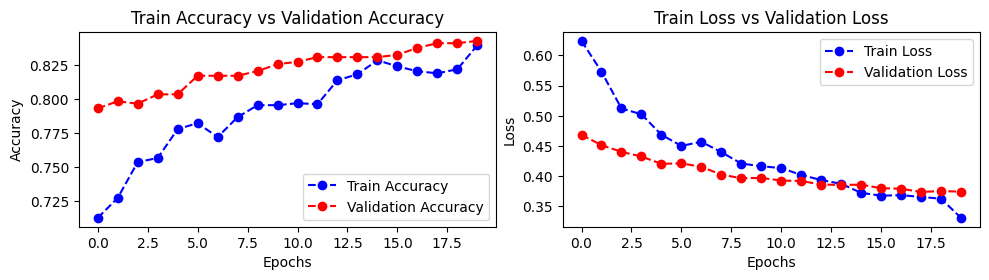

In [175]:
plot_accuracy_loss(model_history)

In [177]:
test_loss = model.evaluate(test_images_resized, test_labels)

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 903ms/step - accuracy: 0.8795 - loss: 0.2867


In [179]:
test_loss

[0.3741365373134613, 0.8427350521087646]

In [183]:
predictions = model.predict(test_images_resized)

19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step


In [185]:
predictions

array([[0.9466291 , 0.05337087],
       [0.9784635 , 0.02153648],
       [0.9868868 , 0.01311314],
       ...,
       [0.98735505, 0.01264491],
       [0.9703161 , 0.02968389],
       [0.97487664, 0.02512335]], dtype=float32)

In [187]:
pred_labels = np.argmax(predictions, axis=1)

In [189]:
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.94      0.90       464
           1       0.66      0.49      0.56       121

    accuracy                           0.84       585
   macro avg       0.77      0.71      0.73       585
weighted avg       0.83      0.84      0.83       585



### Saving the Model

In [192]:
model.save("flood_detection_model.h5")